<a href="https://colab.research.google.com/github/ahwarkhan/DL-IID/blob/main/DL_IID_with_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d962f58ca74e2cd652030f0f449c427b15131ace4fc2139f175826aac9fb0030
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import StandardScaler
import psutil
import time
import random
import math
import lime
import lime.lime_tabular

In [5]:
dataset = pd.read_csv('/content/drive/MyDrive/research_paper/dataset/datatest_7_features_1.csv')

In [6]:
dataset.describe().T

count         mean        std          min          25%  \
2318.4402090840676  44999.0  2400.084634  48.239944  2199.611246  2367.560809   
0.9095661384526199  44999.0     0.008632   3.019591   -13.191679    -2.025444   
-4.139311139656056  44999.0     0.008600   3.004335   -12.668148    -2.024688   
18.89359354792485   44999.0    -0.043499  10.031000   -54.216931    -6.799410   
5.472066192108001   44999.0    -0.260803  40.034246  -155.600356   -27.102140   
0.3299564440962265  44999.0     0.002206   0.997296    -4.103489    -0.675812   
3.611043842811059   44999.0     0.050417   9.982634   -42.007679    -6.679235   

                            50%          75%          max  
2318.4402090840676  2400.045211  2432.608640  2596.367862  
0.9095661384526199    -0.003796     2.035190    12.358836  
-4.139311139656056     0.017977     2.033905    13.023745  
18.89359354792485     -0.069868     6.672912    38.731440  
5.472066192108001      0.081334    26.507046   168.057708  
0.3299564440962265    -0.003181     0.672637     4.535973  
3.611043842811059      0.011707     6.794519    39.439889

In [7]:
dataset.head()

2318.4402090840676  0.9095661384526199  -4.139311139656056  \
0         2369.017404           -1.754597            1.313440   
1         2453.383691            1.088862           -1.227993   
2         2433.591570           -5.839638            3.705717   
3         2459.126812            2.903708            1.819649   
4         2389.078792            1.728807            6.556076   

   18.89359354792485  5.472066192108001  0.3299564440962265  3.611043842811059  
0           3.161897         -34.433554            1.110685         -18.044512  
1          -9.131891         -11.780860           -0.086343          -9.914807  
2           1.830827           5.159389            0.467818         -20.351105  
3           7.543625          27.984036            0.279439          12.624162  
4           6.190018         -34.167965           -0.798856          -7.729004

In [8]:
dataset.shape

(44999, 7)

In [9]:
dataset.isnull().sum()

2318.4402090840676    0
0.9095661384526199    0
-4.139311139656056    0
18.89359354792485     0
5.472066192108001     0
0.3299564440962265    0
3.611043842811059     0
dtype: int64

In [10]:
from sklearn.cluster import KMeans

n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_clusters = kmeans.fit_predict(dataset)

dataset['cluster'] = df_clusters

print(dataset['cluster'].value_counts())

cluster
0    22593
1    22406
Name: count, dtype: int64


In [11]:
dataset.to_csv('/content/drive/MyDrive/research_paper/dataset/clustered_dataset.csv', index=False)

In [12]:
dataset = pd.read_csv('/content/drive/MyDrive/research_paper/dataset/clustered_dataset.csv')

In [13]:
dataset

2318.4402090840676  0.9095661384526199  -4.139311139656056  \
0             2369.017404           -1.754597            1.313440   
1             2453.383691            1.088862           -1.227993   
2             2433.591570           -5.839638            3.705717   
3             2459.126812            2.903708            1.819649   
4             2389.078792            1.728807            6.556076   
...                   ...                 ...                 ...   
44994         2450.296862           -0.649041            1.243733   
44995         2398.655102           -2.493205           -2.233277   
44996         2484.381901            1.244478           -0.711912   
44997         2423.099763           -4.303185            3.233872   
44998         2381.570707            0.006850           -3.105187   

       18.89359354792485  5.472066192108001  0.3299564440962265  \
0               3.161897         -34.433554            1.110685   
1              -9.131891         -11.780860           -0.086343   
2               1.830827           5.159389            0.467818   
3               7.543625          27.984036            0.279439   
4               6.190018         -34.167965           -0.798856   
...                  ...                ...                 ...   
44994          26.162420          76.204476            2.071091   
44995          -1.816925           6.189116            0.039580   
44996          13.597908          17.765552            0.775678   
44997          -5.600552          -7.484681            1.682838   
44998          13.235655         -21.380933            0.616066   

       3.611043842811059  cluster  
0             -18.044512        0  
1              -9.914807        1  
2             -20.351105        1  
3              12.624162        1  
4              -7.729004        0  
...                  ...      ...  
44994          25.522839        1  
44995          -8.127218        0  
44996          -8.039027        1  
44997           8.371839        1  
44998           2.091933        0  

[44999 rows x 8 columns]

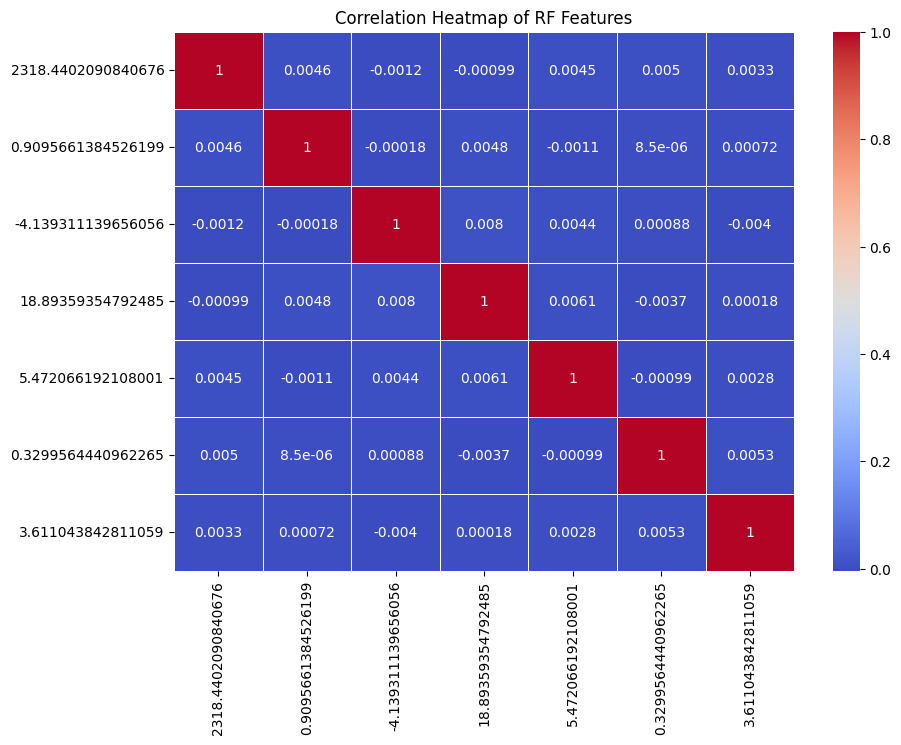

In [16]:
import seaborn as sns

correlation_matrix = dataset.drop(['cluster'], axis=1).corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title("Correlation Heatmap of RF Features", size=12)

plt.show()

In [17]:
X = dataset.drop(['cluster'], axis=1)
y = dataset['cluster']

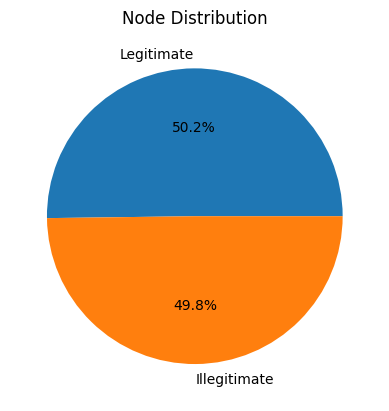

In [18]:
graph_labels = 'Legitimate', 'Illegitimate'
graph_y = y.value_counts()
fig, ax = plt.subplots()
ax.pie(graph_y, labels=graph_labels, autopct='%1.1f%%')
plt.title('Node Distribution')
plt.show()

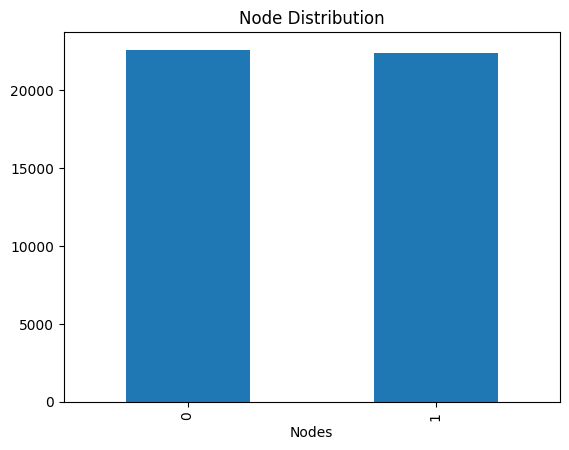

In [19]:
graph_y.plot(kind='bar', xlabel='Nodes')
plt.title('Node Distribution')
plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [22]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        assert len(self.X) == len(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y.iloc[idx]
        return x, y

In [23]:
train_dataset = MyDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = MyDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_dataset = MyDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DNN-BiLSTM

In [25]:
class DNNBiLSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim=64, output_dim=2):
    super(DNNBiLSTM, self).__init__()
    self.dnn = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, hidden_dim)
        )
    self.bilstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(hidden_dim * 2, output_dim)

  def forward(self, x):
    x = self.dnn(x)
    x = x.unsqueeze(1)
    lstm_out, _ = self.bilstm(x)
    lstm_out = lstm_out[:, -1, :]
    output = self.fc(lstm_out)
    return output

  def predict_proba(self, x):
      with torch.no_grad():
          x = torch.tensor(x, dtype=torch.float32)
          output = self.forward(x)
          probabilities = F.softmax(output, dim=1).numpy()
          return probabilities

In [26]:
model = DNNBiLSTM(input_dim=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
def train(model, train_loader, val_loader, val_dataset, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            x, y = batch
            x = x.float()
            y = y.long()
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

        model.eval()
        val_loss = 0
        correct = 0

        with torch.no_grad():
            for batch in val_loader:
                x, y = batch
                x = x.float()
                y = y.long()
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y).sum().item()

        accuracy = correct / len(val_dataset)
        print(f'Validation Loss: {val_loss / len(val_loader)}, Accuracy: {accuracy:.4f}')

In [28]:
train(model, train_loader, val_loader, val_dataset, criterion, optimizer, epochs=20)

Epoch 1, Loss: 0.06934938744826165
Validation Loss: 0.022485887800344363, Accuracy: 0.9908
Epoch 2, Loss: 0.023204389688908124
Validation Loss: 0.019337093744690188, Accuracy: 0.9918
Epoch 3, Loss: 0.015959096911170086
Validation Loss: 0.017679686212448087, Accuracy: 0.9919
Epoch 4, Loss: 0.01340382811486557
Validation Loss: 0.014116051788217763, Accuracy: 0.9938
Epoch 5, Loss: 0.010405631539746942
Validation Loss: 0.014031607251601711, Accuracy: 0.9944
Epoch 6, Loss: 0.009517665691381707
Validation Loss: 0.009248408593086536, Accuracy: 0.9962
Epoch 7, Loss: 0.009428075578125573
Validation Loss: 0.008174345240568233, Accuracy: 0.9958
Epoch 8, Loss: 0.006937029575023593
Validation Loss: 0.008951969316247381, Accuracy: 0.9965
Epoch 9, Loss: 0.00658985552056543
Validation Loss: 0.006719274188973169, Accuracy: 0.9974
Epoch 10, Loss: 0.00724467175382314
Validation Loss: 0.0071975347713530745, Accuracy: 0.9967
Epoch 11, Loss: 0.006799823534085792
Validation Loss: 0.005888606555707366, Accura

In [67]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    predictions = []
    labels = []

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x = x.float()
            y = y.long()
            outputs = model(x)
            loss = nn.CrossEntropyLoss()(outputs, y)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            predictions.extend(predicted.cpu().numpy())
            labels.extend(y.cpu().numpy())

    accuracy = correct / len(test_loader.dataset)
    precision = precision_score(labels, predictions, zero_division=False)
    recall = recall_score(labels, predictions, zero_division=False)
    f1 = f1_score(labels, predictions, zero_division=False)

    process = psutil.Process()
    cpu_utilization = psutil.cpu_percent(interval=1)
    memory_usage = process.memory_info().rss / 1024

    print("\n--- Evaluation Metrics ---")
    print(f"CPU Utilization: {cpu_utilization}%")
    print(f"Memory Usage: {memory_usage} KB")

    print(f'Test Loss: {test_loss / len(test_loader)}')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    print('Classification Report:')
    print(classification_report(labels, predictions))

    confusions = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusions, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()



--- Evaluation Metrics ---
CPU Utilization: 4.5%
Memory Usage: 676076.0 KB
Test Loss: 0.0075628019250277715
Test Accuracy: 0.9969
Precision: 0.9973
Recall: 0.9964
F1 Score: 0.9969
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4526
           1       1.00      1.00      1.00      4474

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000



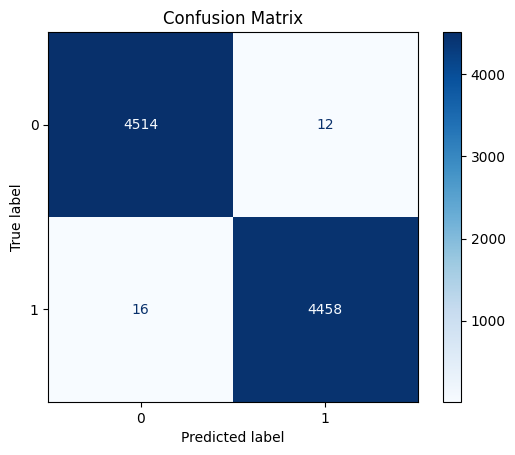

In [68]:
evaluate_model(model, test_loader)

###Fitness (Objective) Function

In [31]:
def train_on_selected_features(selected_features, X, y, epochs=20, batch_size=32):
    selected_features_indices = np.where(selected_features)[0]
    X_selected = X.iloc[:, selected_features_indices]

    scaler = StandardScaler()
    X_selected = scaler.fit_transform(X_selected)

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    train_dataset1 = MyDataset(X_train, y_train)
    train_loader1 = DataLoader(train_dataset1, batch_size=64, shuffle=True)
    val_dataset1 = MyDataset(X_val, y_val)
    val_loader1 = DataLoader(val_dataset1, batch_size=64, shuffle=False)

    input_size = X_train.shape[1]
    model = DNNBiLSTM(input_dim=input_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader1:
            x, y = batch
            x = x.float()
            y = y.long()
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        correct = 0

        with torch.no_grad():
            for batch in val_loader1:
                x, y = batch
                x = x.float()
                y = y.long()
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y).sum().item()

        accuracy = correct / len(val_dataset1)

        return 1 - accuracy

In [32]:
class solution:
    def __init__(self):
        self.best = 0
        self.bestIndividual = []
        self.convergence = []
        self.optimizer = ""
        self.objfname = ""
        self.startTime = 0
        self.endTime = 0
        self.executionTime = 0
        self.lb = 0
        self.ub = 0
        self.dim = 0
        self.popnum = 0
        self.maxiers = 0

### GA

In [33]:
def crossover(individualLength, parent1, parent2):
    crossover_point = random.randint(1, individualLength - 1)
    offspring1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
    offspring2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
    return offspring1, offspring2

In [34]:
def mutation(individual, individualLength, lb, ub):
    mutationIndex = random.randint(0, individualLength - 1)
    individual[mutationIndex] = 1 - individual[mutationIndex]

In [35]:
def pairSelection(population, scores, popSize):
    def rouletteWheelSelectionId(scores, popSize):
        total_fitness = sum(scores)
        normalized_scores = [score / total_fitness for score in scores]
        cumulative_probs = np.cumsum(normalized_scores)
        random_num = random.random()
        for i, cumulative_prob in enumerate(cumulative_probs):
            if random_num <= cumulative_prob:
                return i

    parent1Id = rouletteWheelSelectionId(scores, popSize)
    parent1 = population[parent1Id].copy()

    parent2Id = parent1Id
    while parent2Id == parent1Id:
        parent2Id = rouletteWheelSelectionId(scores, popSize)

    parent2 = population[parent2Id].copy()

    return parent1, parent2

In [36]:
def mutatePopulaton(population, popSize, mutationProbability, keep, lb, ub):
    for i in range(keep, popSize):
        if random.random() < mutationProbability:
            mutation(population[i], len(population[i]), lb, ub)

In [37]:
def sortPopulation(population, scores):
    sorted_indices = scores.argsort()
    population = population[sorted_indices]
    scores = scores[sorted_indices]
    return population, scores

In [38]:
def crossoverPopulaton(population, scores, popSize, crossoverProbability, keep):
    newPopulation = np.zeros_like(population)
    newPopulation[:keep] = population[:keep]

    for i in range(keep, popSize, 2):
        parent1, parent2 = pairSelection(population, scores, popSize)
        individualLength = len(parent1)

        if random.random() < crossoverProbability:
            offspring1, offspring2 = crossover(individualLength, parent1, parent2)
        else:
            offspring1, offspring2 = parent1.copy(), parent2.copy()

        newPopulation[i] = offspring1
        if i + 1 < popSize:
            newPopulation[i + 1] = offspring2

    return newPopulation

In [39]:
def clearDups(population, lb, ub):
    unique_population = np.unique(population, axis=0)
    num_duplicates = len(population) - len(unique_population)

    if num_duplicates > 0:
        random_individuals = np.random.randint(2, size=(num_duplicates, population.shape[1]))
        unique_population = np.vstack((unique_population, random_individuals))

    return unique_population

In [40]:
def GA(objf, lb, ub, dim, popSize, iters):
    cp = 0.8
    mp = 0.05
    keep = 2
    s = solution()

    bestScore = float("inf")
    bestIndividual = None

    ga = np.random.randint(2, size=(popSize, dim))
    convergence_curve = np.zeros(iters)

    print('GA is optimizing "' + objf.__name__ + '" for feature selection')

    timerStart = time.time()
    s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")

    for l in range(iters):
        scores = np.array([objf(ind) for ind in ga])

        ga, scores = sortPopulation(ga, scores)

        if scores[0] < bestScore:
            bestScore = scores[0]
            bestIndividual = ga[0]

        convergence_curve[l] = bestScore

        if l % 1 == 0:
            print(f"Iteration {l + 1}, best fitness (error): {bestScore}")

        ga = crossoverPopulaton(ga, scores, popSize, cp, keep)
        mutatePopulaton(ga, popSize, mp, keep, lb, ub)
        ga = clearDups(ga, lb, ub)

    timerEnd = time.time()
    s.bestIndividual = bestIndividual
    s.bestScore = bestScore
    s.executionTime = timerEnd - timerStart
    s.convergence = convergence_curve
    s.optimizer = "GA"
    s.objfname = objf.__name__

    return s

In [41]:
dim = X.shape[1]
lb = [0] * dim
ub = [1] * dim
popSize = 10
iters = 5

In [42]:
def objective(selected_features):
  return train_on_selected_features(selected_features, X, y)

In [43]:
best_solution = GA(objective, lb, ub, dim, popSize, iters)

print(f"Best feature set: {best_solution.bestIndividual}")
print(f"Best accuracy (1 - best error): {1 - best_solution.bestScore}")

GA is optimizing "objective" for feature selection
Iteration 1, best fitness (error): 0.005138888888888915
Iteration 2, best fitness (error): 0.003750000000000031
Iteration 3, best fitness (error): 0.003750000000000031
Iteration 4, best fitness (error): 0.003750000000000031
Iteration 5, best fitness (error): 0.003750000000000031
Best feature set: [1 1 0 0 1 0 0]
Best accuracy (1 - best error): 0.99625


###GWO

In [44]:
def GWO(objf, lb, ub, dim, SearchAgents_no, Max_iter):
    Alpha_pos = np.zeros(dim)
    Alpha_score = float("inf")

    Beta_pos = np.zeros(dim)
    Beta_score = float("inf")

    Delta_pos = np.zeros(dim)
    Delta_score = float("inf")

    Positions = np.random.randint(0, 2, (SearchAgents_no, dim))

    Convergence_curve = np.zeros(Max_iter)
    s = solution()

    print('GWO is optimizing  "' + objf.__name__ + '"')
    timerStart = time.time()
    s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")

    for l in range(Max_iter):
        for i in range(SearchAgents_no):
            fitness = objf(Positions[i])

            if fitness < Alpha_score:
                Delta_score = Beta_score
                Delta_pos = Beta_pos.copy()
                Beta_score = Alpha_score
                Beta_pos = Alpha_pos.copy()
                Alpha_score = fitness
                Alpha_pos = Positions[i].copy()

            elif fitness < Beta_score:
                Delta_score = Beta_score
                Delta_pos = Beta_pos.copy()
                Beta_score = fitness
                Beta_pos = Positions[i].copy()

            elif fitness < Delta_score:
                Delta_score = fitness
                Delta_pos = Positions[i].copy()

        a = 2 - l * ((2) / Max_iter)

        for i in range(SearchAgents_no):
            for j in range(dim):
                r1, r2 = random.random(), random.random()
                A1, C1 = 2 * a * r1 - a, 2 * r2
                D_alpha = abs(C1 * Alpha_pos[j] - Positions[i, j])
                X1 = Alpha_pos[j] - A1 * D_alpha

                r1, r2 = random.random(), random.random()
                A2, C2 = 2 * a * r1 - a, 2 * r2
                D_beta = abs(C2 * Beta_pos[j] - Positions[i, j])
                X2 = Beta_pos[j] - A2 * D_beta

                r1, r2 = random.random(), random.random()
                A3, C3 = 2 * a * r1 - a, 2 * r2
                D_delta = abs(C3 * Delta_pos[j] - Positions[i, j])
                X3 = Delta_pos[j] - A3 * D_delta

                Positions[i, j] = 1 if ((X1 + X2 + X3) / 3) > 0.5 else 0

        Convergence_curve[l] = Alpha_score

        if l % 1 == 0:
            print(f"At iteration {l}, the best fitness is {Alpha_score:.4f}")

    timerEnd = time.time()
    s.endTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    s.executionTime = timerEnd - timerStart
    s.convergence = Convergence_curve
    s.optimizer = "GWO"
    s.bestIndividual = Alpha_pos
    s.objfname = objf.__name__

    return s

In [46]:
s = GWO(objective, lb=0, ub=1, dim=X.shape[1], SearchAgents_no=10, Max_iter=5)
print("Best Features Selected:", [i for i, x in enumerate(s.bestIndividual) if x == 1])
print("Best Fitness Score:", min(s.convergence))
print("Best Accuracy:", 1 - min(s.convergence))

GWO is optimizing  "objective"
At iteration 0, the best fitness is 0.0085
At iteration 1, the best fitness is 0.0057
At iteration 2, the best fitness is 0.0057
At iteration 3, the best fitness is 0.0047
At iteration 4, the best fitness is 0.0047
Best Features Selected: [0, 3, 4, 5]
Best Fitness Score: 0.004722222222222183
Best Accuracy: 0.9952777777777778


In [47]:
selected_features_ga = best_solution.bestIndividual
selected_features_gwo = s.bestIndividual

In [48]:
selected_features_ga

array([1, 1, 0, 0, 1, 0, 0])

In [49]:
selected_features_gwo

array([1, 0, 0, 1, 1, 1, 0])

In [50]:
selected_features_ga_original = [X.columns[i] for i, x in enumerate(selected_features_ga) if x == 1]
print(selected_features_ga_original)
print(len(selected_features_ga_original))

['2318.4402090840676', '0.9095661384526199', '5.472066192108001']
3


In [51]:
selected_features_gwo_original = [X.columns[i] for i, x in enumerate(selected_features_gwo) if x == 1]
print(selected_features_gwo_original)
print(len(selected_features_gwo_original))

['2318.4402090840676', '18.89359354792485', '5.472066192108001', '0.3299564440962265']
4


In [52]:
weights_ga = [1 if x in selected_features_ga_original else 0 for x in X.columns]
print(weights_ga)

[1, 1, 0, 0, 1, 0, 0]


In [53]:
weights_gwo = [1 if x in selected_features_gwo_original else 0 for x in X.columns]
print(weights_gwo)

[1, 0, 0, 1, 1, 1, 0]


### Combined Features

In [54]:
combined_weights = [max(x, y) for x, y in zip(weights_ga, weights_gwo)]

In [55]:
combined_features = [x for x, w in zip(X.columns, combined_weights) if w > 0]

In [56]:
combined_features

['2318.4402090840676',
 '0.9095661384526199',
 '18.89359354792485',
 '5.472066192108001',
 '0.3299564440962265']

In [57]:
len(combined_features)

5

In [73]:
combined_features_indices = [X.columns.get_loc(col) for col in combined_features]

In [74]:
X_selected_combined = X.iloc[:, combined_features_indices]

In [75]:
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_selected_combined, y, test_size=0.3, random_state=42)
X_train_combined, X_val_combined, y_train_combined, y_val_combined = train_test_split(X_train_combined, y_train_combined, test_size=0.2, random_state=42)

In [76]:
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)
X_val_combined = scaler.transform(X_val_combined)

In [77]:
train_dataset_combined = MyDataset(X_train_combined, y_train_combined)
train_loader_combined = DataLoader(train_dataset_combined, batch_size=64, shuffle=True)
test_dataset_combined = MyDataset(X_test_combined, y_test_combined)
test_loader_combined = DataLoader(test_dataset_combined, batch_size=64, shuffle=False)
val_dataset_combined = MyDataset(X_val_combined, y_val_combined)
val_loader_combined = DataLoader(val_dataset_combined, batch_size=64, shuffle=False)

In [78]:
model_combined = DNNBiLSTM(input_dim=X_train_combined.shape[1])
optimizer_combined = optim.Adam(model_combined.parameters(), lr=0.001)

In [79]:
train(model_combined, train_loader_combined, val_loader_combined, val_dataset_combined, criterion, optimizer_combined, epochs=20)

Epoch 1, Loss: 0.07050244413484816
Validation Loss: 0.026742084386330474, Accuracy: 0.9894
Epoch 2, Loss: 0.01885052050327865
Validation Loss: 0.014096855391857609, Accuracy: 0.9957
Epoch 3, Loss: 0.014598384930596108
Validation Loss: 0.010754364621559466, Accuracy: 0.9959
Epoch 4, Loss: 0.010555104356602306
Validation Loss: 0.008168694243701766, Accuracy: 0.9965
Epoch 5, Loss: 0.011691222410976719
Validation Loss: 0.011423761537309585, Accuracy: 0.9949
Epoch 6, Loss: 0.008370863144709294
Validation Loss: 0.01763506326861174, Accuracy: 0.9948
Epoch 7, Loss: 0.009908713406698067
Validation Loss: 0.011193389087713163, Accuracy: 0.9941
Epoch 8, Loss: 0.007853526444016448
Validation Loss: 0.008775366177599268, Accuracy: 0.9967
Epoch 9, Loss: 0.0059999525222870055
Validation Loss: 0.015025208290307542, Accuracy: 0.9954
Epoch 10, Loss: 0.0062333610750946655
Validation Loss: 0.007218839022096639, Accuracy: 0.9975
Epoch 11, Loss: 0.005214356730197886
Validation Loss: 0.013201188239263778, Accu


--- Evaluation Metrics ---
CPU Utilization: 4.0%
Memory Usage: 682660.0 KB
Test Loss: 0.005076352431913801
Test Accuracy: 0.9981
Precision: 0.9975
Recall: 0.9988
F1 Score: 0.9981
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6771
           1       1.00      1.00      1.00      6729

    accuracy                           1.00     13500
   macro avg       1.00      1.00      1.00     13500
weighted avg       1.00      1.00      1.00     13500



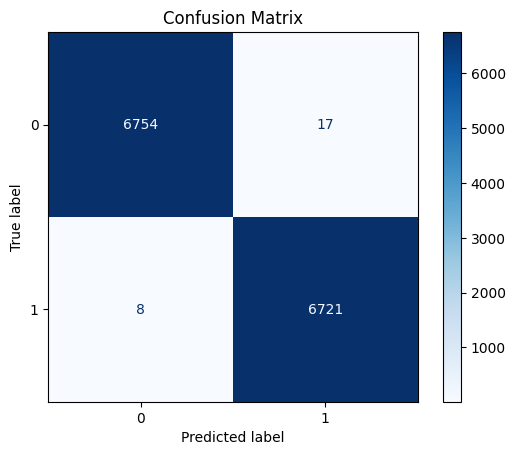

In [80]:
evaluate_model(model_combined, test_loader_combined)

### GA Features

In [58]:
ga_features_indices = [X.columns.get_loc(col) for col in selected_features_ga_original]

In [59]:
X_selected_ga = X.iloc[:, ga_features_indices]

In [60]:
X_train_selected_ga, X_test_selected_ga, y_train_selected_ga, y_test_selected_ga = train_test_split(X_selected_ga, y, test_size=0.3, random_state=42)
X_train_selected_ga, X_val_selected_ga, y_train_selected_ga, y_val_selected_ga = train_test_split(X_train_selected_ga, y_train_selected_ga, test_size=0.2, random_state=42)

In [61]:
X_train_selected_ga = scaler.fit_transform(X_train_selected_ga)
X_test_selected_ga = scaler.transform(X_test_selected_ga)
X_val_selected_ga = scaler.transform(X_val_selected_ga)

In [63]:
train_dataset_selected_ga = MyDataset(X_train_selected_ga, y_train_selected_ga)
train_loader_selected_ga = DataLoader(train_dataset_selected_ga, batch_size=64, shuffle=True)
test_dataset_selected_ga = MyDataset(X_test_selected_ga, y_test_selected_ga)
test_loader_selected_ga = DataLoader(test_dataset_selected_ga, batch_size=64, shuffle=False)
val_dataset_selected_ga = MyDataset(X_val_selected_ga, y_val_selected_ga)
val_loader_selected_ga = DataLoader(val_dataset_selected_ga, batch_size=64, shuffle=False)

In [64]:
model_selected_ga = DNNBiLSTM(input_dim=X_train_selected_ga.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer_selected_ga = optim.Adam(model_selected_ga.parameters(), lr=0.001)

In [65]:
train(model_selected_ga, train_loader_selected_ga, val_loader_selected_ga, val_dataset_selected_ga, criterion, optimizer_selected_ga, epochs=20)

Epoch 1, Loss: 0.056878579067895695
Validation Loss: 0.04697399274859109, Accuracy: 0.9810
Epoch 2, Loss: 0.016567763708066157
Validation Loss: 0.012900215990896987, Accuracy: 0.9949
Epoch 3, Loss: 0.011403747949364787
Validation Loss: 0.007200926012340672, Accuracy: 0.9967
Epoch 4, Loss: 0.008895904567268149
Validation Loss: 0.004756903334679799, Accuracy: 0.9987
Epoch 5, Loss: 0.009397237589722041
Validation Loss: 0.008932229858559864, Accuracy: 0.9957
Epoch 6, Loss: 0.007589042640028412
Validation Loss: 0.004196409446757286, Accuracy: 0.9984
Epoch 7, Loss: 0.007540291565252687
Validation Loss: 0.004046550209359982, Accuracy: 0.9986
Epoch 8, Loss: 0.005920441968473443
Validation Loss: 0.005740036930771998, Accuracy: 0.9973
Epoch 9, Loss: 0.0058117825255180255
Validation Loss: 0.005992995340450605, Accuracy: 0.9971
Epoch 10, Loss: 0.005879442165414753
Validation Loss: 0.006853603217416204, Accuracy: 0.9967
Epoch 11, Loss: 0.005323867199722903
Validation Loss: 0.006113445798337584, Acc


--- Evaluation Metrics ---
CPU Utilization: 5.0%
Memory Usage: 676324.0 KB
Test Loss: 0.002639785622267443
Test Accuracy: 0.9990
Precision: 0.9996
Recall: 0.9985
F1 Score: 0.9990
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6771
           1       1.00      1.00      1.00      6729

    accuracy                           1.00     13500
   macro avg       1.00      1.00      1.00     13500
weighted avg       1.00      1.00      1.00     13500



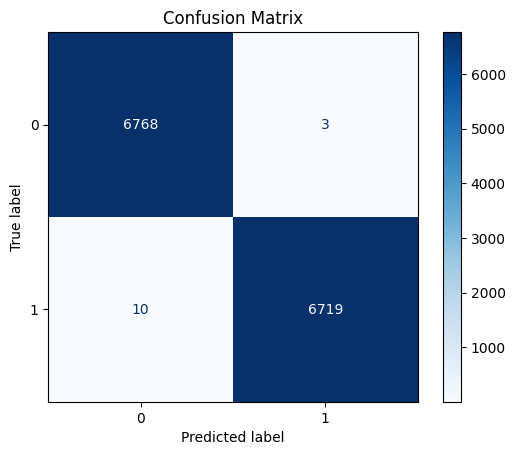

In [70]:
evaluate_model(model_selected_ga, test_loader_selected_ga)

### GWO Features

In [62]:
gwo_features_indices = [X.columns.get_loc(col) for col in selected_features_gwo_original]

In [71]:
X_selected_gwo = X.iloc[:, gwo_features_indices]

In [72]:
X_train_selected_gwo, X_test_selected_gwo, y_train_selected_gwo, y_test_selected_gwo = train_test_split(X_selected_gwo, y, test_size=0.3, random_state=42)
X_train_selected_gwo, X_val_selected_gwo, y_train_selected_gwo, y_val_selected_gwo = train_test_split(X_train_selected_gwo, y_train_selected_gwo, test_size=0.2, random_state=42)

In [81]:
X_train_selected_gwo = scaler.fit_transform(X_train_selected_gwo)
X_test_selected_gwo = scaler.transform(X_test_selected_gwo)
X_val_selected_gwo = scaler.transform(X_val_selected_gwo)

In [82]:
train_dataset_selected_gwo = MyDataset(X_train_selected_gwo, y_train_selected_gwo)
train_loader_selected_gwo = DataLoader(train_dataset_selected_gwo, batch_size=64, shuffle=True)
test_dataset_selected_gwo = MyDataset(X_test_selected_gwo, y_test_selected_gwo)
test_loader_selected_gwo = DataLoader(test_dataset_selected_gwo, batch_size=64, shuffle=False)
val_dataset_selected_gwo = MyDataset(X_val_selected_gwo, y_val_selected_gwo)
val_loader_selected_gwo = DataLoader(val_dataset_selected_gwo, batch_size=64, shuffle=False)

In [83]:
model_selected_gwo = DNNBiLSTM(input_dim=X_train_selected_gwo.shape[1])
optimizer_selected_gwo = optim.Adam(model_selected_gwo.parameters(), lr=0.001)

In [84]:
train(model_selected_gwo, train_loader_selected_gwo, val_loader_selected_gwo, val_dataset_selected_gwo, criterion, optimizer_selected_gwo, epochs=20)

Epoch 1, Loss: 0.06732738547740376
Validation Loss: 0.03705085758716597, Accuracy: 0.9832
Epoch 2, Loss: 0.018986590923937393
Validation Loss: 0.02459678608041334, Accuracy: 0.9894
Epoch 3, Loss: 0.013029395538123613
Validation Loss: 0.01612569349871399, Accuracy: 0.9927
Epoch 4, Loss: 0.011540871123587043
Validation Loss: 0.010727712126210482, Accuracy: 0.9949
Epoch 5, Loss: 0.008677765733842433
Validation Loss: 0.008639439411461978, Accuracy: 0.9968
Epoch 6, Loss: 0.007542379302352519
Validation Loss: 0.025959350639924297, Accuracy: 0.9913
Epoch 7, Loss: 0.008935512957058503
Validation Loss: 0.016390831861468596, Accuracy: 0.9937
Epoch 8, Loss: 0.007144175838439984
Validation Loss: 0.0100884917627708, Accuracy: 0.9956
Epoch 9, Loss: 0.007315653558034775
Validation Loss: 0.014528502736511378, Accuracy: 0.9946
Epoch 10, Loss: 0.006025271366400325
Validation Loss: 0.005357155887882394, Accuracy: 0.9978
Epoch 11, Loss: 0.006396831893357673
Validation Loss: 0.0076754748510339975, Accuracy


--- Evaluation Metrics ---
CPU Utilization: 3.5%
Memory Usage: 688468.0 KB
Test Loss: 0.011559031142393228
Test Accuracy: 0.9957
Precision: 0.9916
Recall: 0.9999
F1 Score: 0.9957
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6771
           1       0.99      1.00      1.00      6729

    accuracy                           1.00     13500
   macro avg       1.00      1.00      1.00     13500
weighted avg       1.00      1.00      1.00     13500



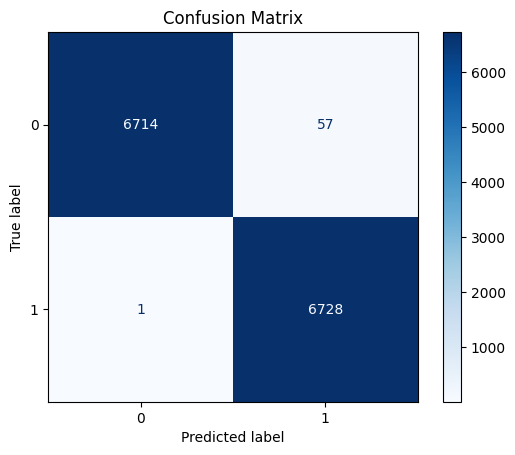

In [86]:
evaluate_model(model_selected_gwo, test_loader_selected_gwo)

### LIME for DNN-BiLSTM with All Features

In [87]:
explainer1 = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                   feature_names=X.columns.tolist(),
                                                   mode='classification',
                                                   discretize_continuous=True)

In [88]:
i = 10
exp1 = explainer1.explain_instance(
    data_row=X_test[i],
    predict_fn=model.predict_proba,
    num_features=X_train.shape[1]
)

In [89]:
y_test_selected_ga.iloc[i]

0

In [90]:
exp1.show_in_notebook(show_table=True, show_predicted_value=True)

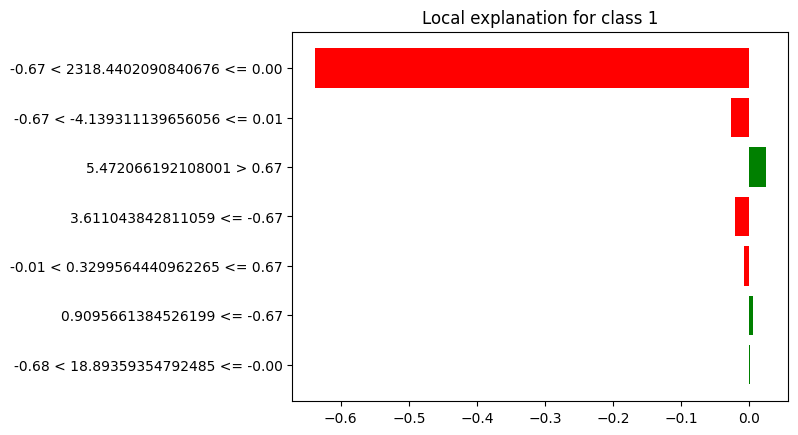

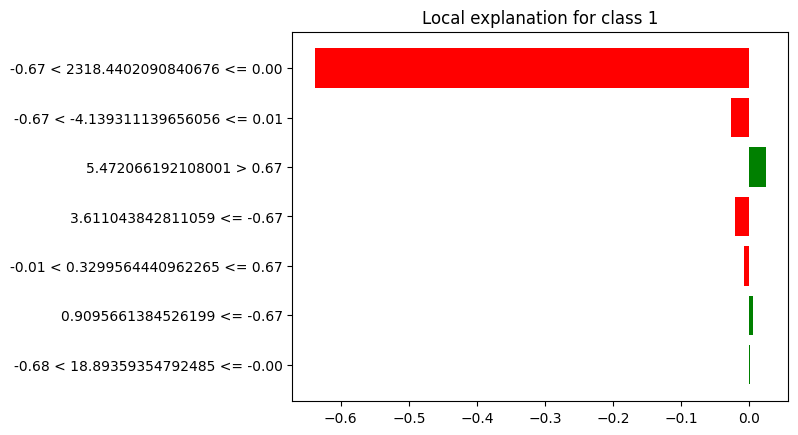

In [91]:
exp1.as_pyplot_figure()

In [92]:
exp1.save_to_file('/content/drive/MyDrive/research_paper/lime_explanation.html')

In [93]:
feature_contributions1 = exp1.as_map()[1]
print("Feature Contributions (index-based):", feature_contributions1)

Feature Contributions (index-based): [(0, -0.6380799897513418), (2, -0.025784495114890796), (4, 0.02474466696122386), (6, -0.020633630786115194), (5, -0.007734471054760406), (1, 0.005287828378383831), (3, 0.0016811314233419617)]


### LIME for DNN-BiLSTM with GA Features

In [94]:
explainer2 = lime.lime_tabular.LimeTabularExplainer(X_train_selected_ga,
                                                   feature_names=X_selected_ga,
                                                   mode='classification',
                                                   discretize_continuous=True)

In [95]:
j=10
exp2 = explainer2.explain_instance(
    data_row=X_test_selected_ga[j],
    predict_fn=model_selected_ga.predict_proba,
    num_features=X_train_selected_ga.shape[1]
)

In [96]:
exp2.show_in_notebook(show_table=True, show_predicted_value=True)

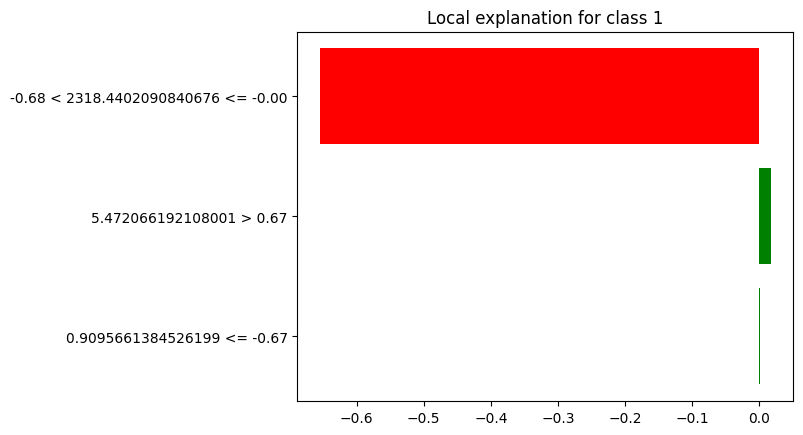

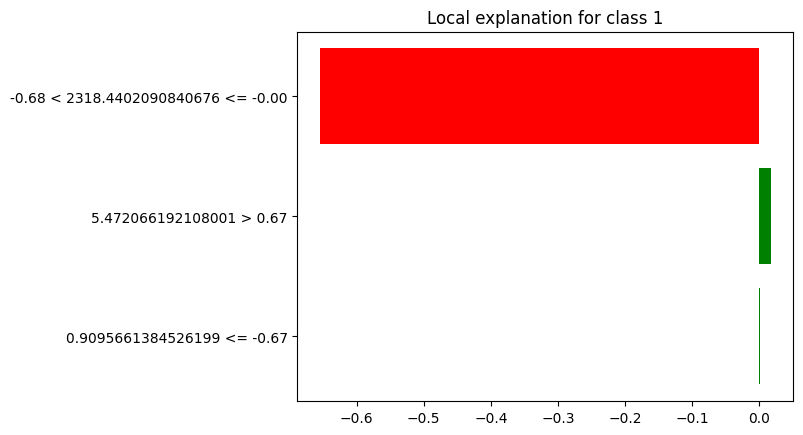

In [97]:
exp2.as_pyplot_figure()

In [98]:
exp2.save_to_file('/content/drive/MyDrive/research_paper/lime_explanation_ga.html')

In [99]:
feature_contributions2 = exp2.as_map()[1]
print("Feature Contributions (index-based):", feature_contributions2)

Feature Contributions (index-based): [(0, -0.6548733447709297), (2, 0.01673155704323147), (1, 0.0004428647658937667)]


### LIME for DNN-BiLSTM with GWO Features

In [100]:
explainer3 = lime.lime_tabular.LimeTabularExplainer(X_train_selected_gwo,
                                                   feature_names=X_selected_gwo,
                                                   mode='classification',
                                                   discretize_continuous=True)

In [101]:
k=10
exp3 = explainer3.explain_instance(
    data_row=X_test_selected_gwo[k],
    predict_fn=model_selected_gwo.predict_proba,
    num_features=X_train_selected_gwo.shape[1]
)

In [102]:
exp3.show_in_notebook(show_table=True, show_predicted_value=True)

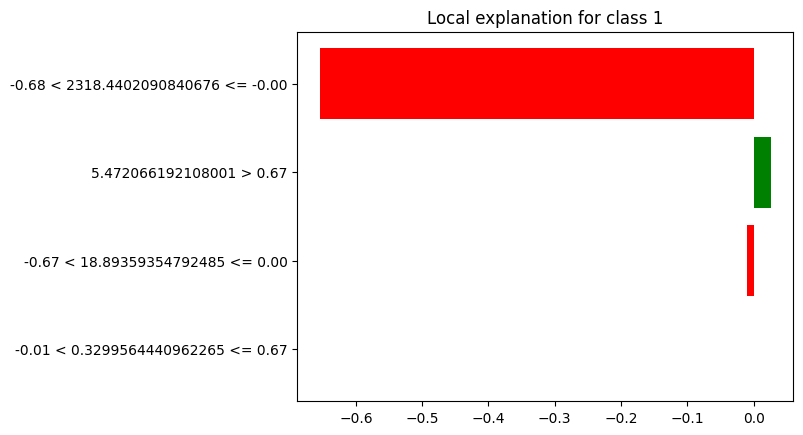

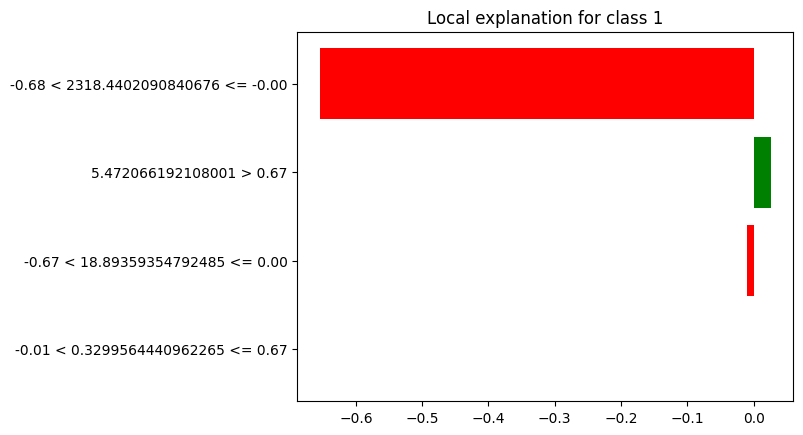

In [103]:
exp3.as_pyplot_figure()

In [104]:
exp3.save_to_file('/content/drive/MyDrive/research_paper/lime_explanation_gwo.html')

In [105]:
feature_contributions3 = exp3.as_map()[1]
print("Feature Contributions (index-based):", feature_contributions3)

Feature Contributions (index-based): [(0, -0.6544638443006807), (2, 0.025697252139126842), (1, -0.010401383646930173), (3, -0.00017581013434611346)]


## LIME Explanation for Combined Features

In [106]:
explainer4 = lime.lime_tabular.LimeTabularExplainer(X_train_combined,
                                                   feature_names=X_selected_combined,
                                                   mode='classification',
                                                   discretize_continuous=True)

In [107]:
l = 10
exp4 = explainer4.explain_instance(
    data_row=X_test_combined[l],
    predict_fn=model_combined.predict_proba,
    num_features=X_train_combined.shape[1]
)

In [108]:
exp4.show_in_notebook(show_table=True, show_predicted_value=True)

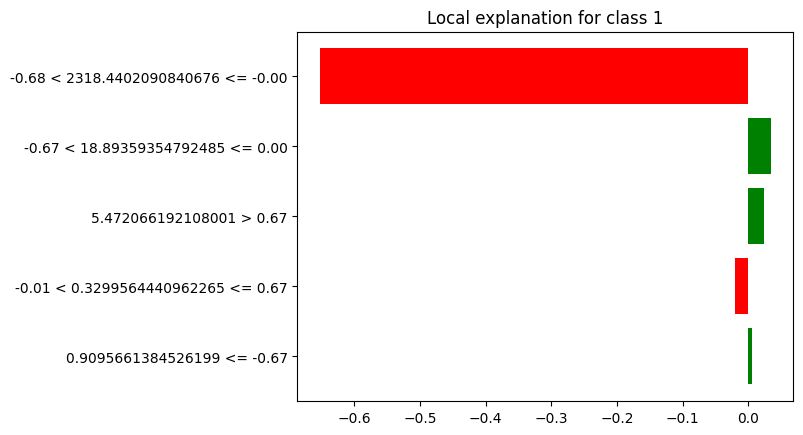

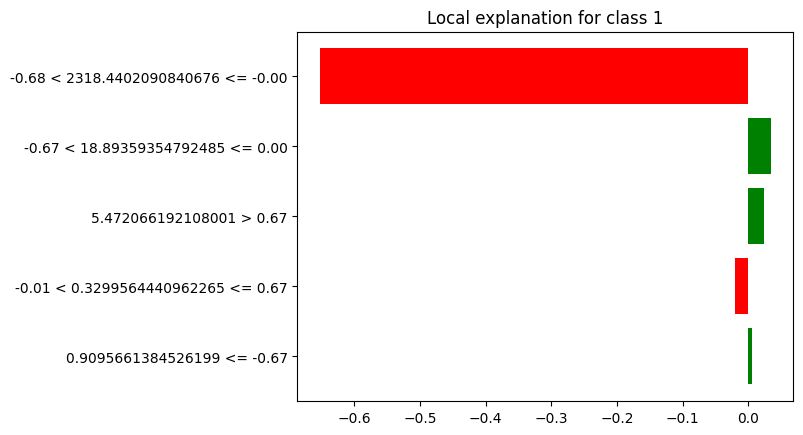

In [109]:
exp4.as_pyplot_figure()

In [110]:
exp4.save_to_file('/content/drive/MyDrive/research_paper/lime_explanation_combined.html')

Model Size

In [111]:
torch.save(model.state_dict(), '/content/drive/MyDrive/research_paper/dnn_bilstm_model.pth')

model_size1 = os.path.getsize('/content/drive/MyDrive/research_paper/dnn_bilstm_model.pth') / 1024
print(f"Model Size: {model_size1:.2f} KB")

Model Size: 302.14 KB


In [112]:
torch.save(model_selected_ga.state_dict(), '/content/drive/MyDrive/research_paper/ga_selected_model.pth')

model_size_ga = os.path.getsize('/content/drive/MyDrive/research_paper/ga_selected_model.pth') / 1024
print(f"Model Size: {model_size_ga:.2f} KB")

Model Size: 300.16 KB


In [113]:
torch.save(model_selected_gwo.state_dict(), '/content/drive/MyDrive/research_paper/gwo_selected_model.pth')

model_size_gwo = os.path.getsize('/content/drive/MyDrive/research_paper/gwo_selected_model.pth') / 1024
print(f"Model Size: {model_size_gwo:.2f} KB")

Model Size: 300.67 KB


In [114]:
torch.save(model_combined.state_dict(), '/content/drive/MyDrive/research_paper/combined_model.pth')

model_size_combined = os.path.getsize('/content/drive/MyDrive/research_paper/combined_model.pth') / 1024
print(f"Model Size: {model_size_combined:.2f} KB")

Model Size: 301.10 KB


### Dynamic Quantization model

In [115]:
import torch.quantization
quantized_model_ga = torch.quantization.quantize_dynamic(
    model_selected_ga,
    {nn.LSTM},
    dtype=torch.qint8
)


--- Evaluation Metrics ---
CPU Utilization: 3.5%
Memory Usage: 735460.0 KB
Test Loss: 0.002811105351421674
Test Accuracy: 0.9991
Precision: 0.9994
Recall: 0.9988
F1 Score: 0.9991
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6771
           1       1.00      1.00      1.00      6729

    accuracy                           1.00     13500
   macro avg       1.00      1.00      1.00     13500
weighted avg       1.00      1.00      1.00     13500



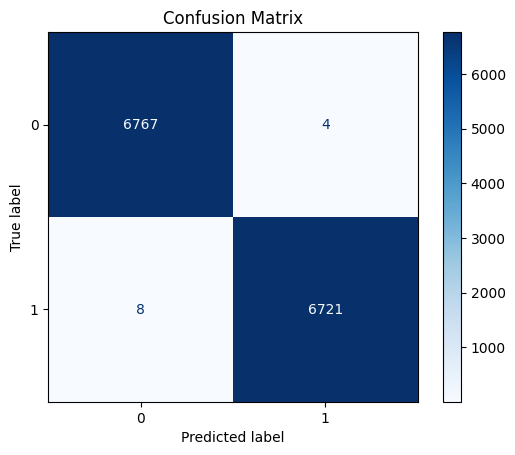

In [116]:
evaluate_model(quantized_model_ga, test_loader_selected_ga)

In [117]:
torch.save(quantized_model_ga.state_dict(), '/content/drive/MyDrive/research_paper/ga_quantised_model.pth')

quantized_ga_size = os.path.getsize('/content/drive/MyDrive/research_paper/ga_quantised_model.pth') / 1024
print(f"Model Size: {quantized_ga_size:.2f} KB")

Model Size: 108.92 KB


In [118]:
quantized_model_gwo = torch.quantization.quantize_dynamic(
    model_selected_gwo,
    {nn.LSTM},
    dtype=torch.qint8
)


--- Evaluation Metrics ---
CPU Utilization: 4.0%
Memory Usage: 735460.0 KB
Test Loss: 0.01073761684488931
Test Accuracy: 0.9958
Precision: 0.9917
Recall: 0.9999
F1 Score: 0.9958
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6771
           1       0.99      1.00      1.00      6729

    accuracy                           1.00     13500
   macro avg       1.00      1.00      1.00     13500
weighted avg       1.00      1.00      1.00     13500



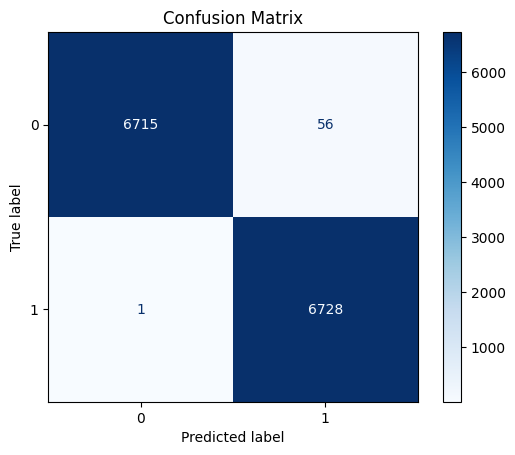

In [119]:
evaluate_model(quantized_model_gwo, test_loader_selected_gwo)

In [120]:
torch.save(quantized_model_gwo.state_dict(), '/content/drive/MyDrive/research_paper/gwo_quantised_model.pth')

quantized_gwo_size = os.path.getsize('/content/drive/MyDrive/research_paper/gwo_quantised_model.pth') / 1024
print(f"Model Size: {quantized_gwo_size:.2f} KB")

Model Size: 109.44 KB


In [121]:
quantized_model_combined = torch.quantization.quantize_dynamic(
    model_combined,
    {nn.LSTM},
    dtype=torch.qint8
)


--- Evaluation Metrics ---
CPU Utilization: 3.0%
Memory Usage: 735460.0 KB
Test Loss: 0.005564009304003491
Test Accuracy: 0.9980
Precision: 0.9976
Recall: 0.9984
F1 Score: 0.9980
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6771
           1       1.00      1.00      1.00      6729

    accuracy                           1.00     13500
   macro avg       1.00      1.00      1.00     13500
weighted avg       1.00      1.00      1.00     13500



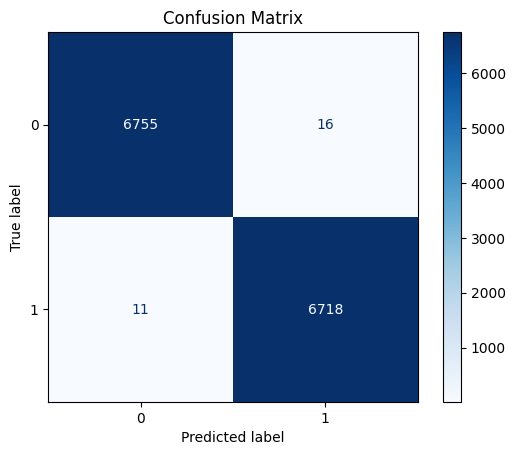

In [128]:
evaluate_model(quantized_model_combined, test_loader_combined)

In [124]:
torch.save(quantized_model_combined.state_dict(), '/content/drive/MyDrive/research_paper/combined_quantised_model.pth')

quantized_combined_size = os.path.getsize('/content/drive/MyDrive/research_paper/combined_quantised_model.pth') / 1024
print(f"Model Size: {quantized_combined_size:.2f} KB")

Model Size: 110.09 KB
